Data Augmentation usando tf.image
===

* *30 min* | Última modificación: Abril 8, 2020.

Basado en https://www.tensorflow.org/tutorials/images/data_augmentation

## Importación de librerías

In [1]:
import os
import urllib
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

print(tf.__version__)
print(hub.__version__)

AUTOTUNE = tf.data.experimental.AUTOTUNE

#
# Librerias adicionales para graficación
#
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.1.0
0.8.0


## Transformación de una sola imagen

### Preparación

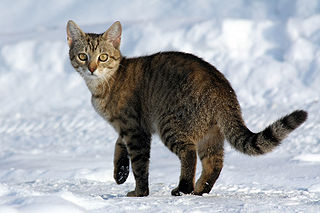

In [2]:
image_path = tf.keras.utils.get_file(
    "cat.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg",
)

Image.open(image_path)

In [3]:
#
#  Carga y decodificación de la imágen
#
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3)

In [4]:
#
#  Función para visualizar y compara dos imágenes
#
def visualize(original, augmented):
    
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented)

### Voltear la imágen

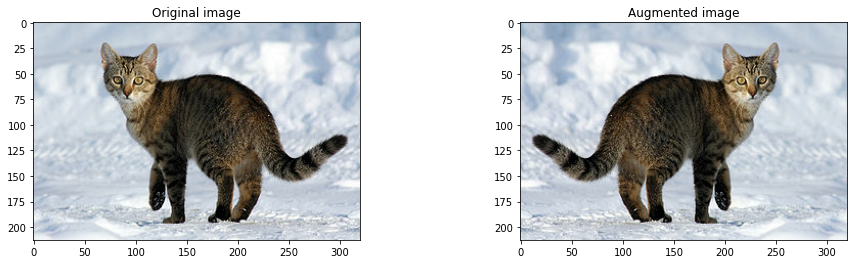

In [5]:
visualize(image, tf.image.flip_left_right(image))

### Cambiar a una escala de colores

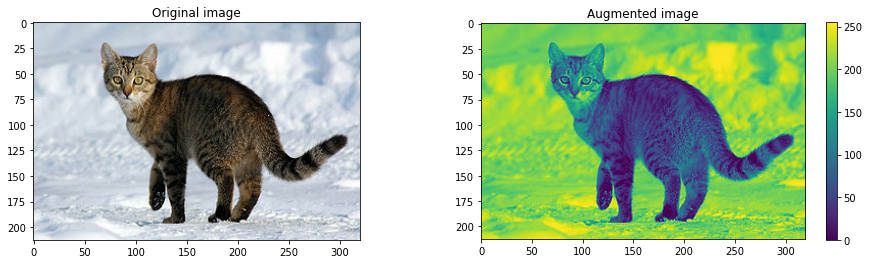

In [6]:
visualize(image, tf.squeeze(tf.image.rgb_to_grayscale(image)))
plt.colorbar();

### Saturación 

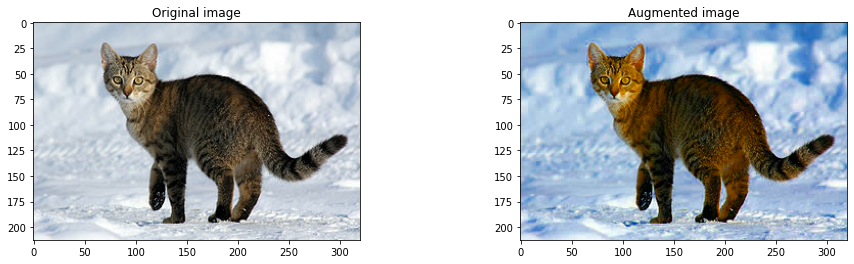

In [7]:
visualize(image, tf.image.adjust_saturation(image, 3))

### Cambio del brillo

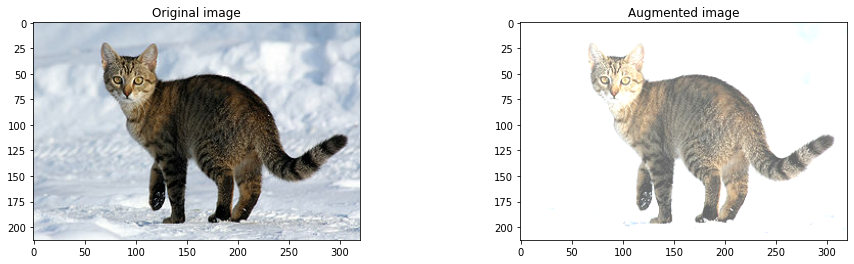

In [8]:
visualize(image, tf.image.adjust_brightness(image, 0.4))

### Rotación

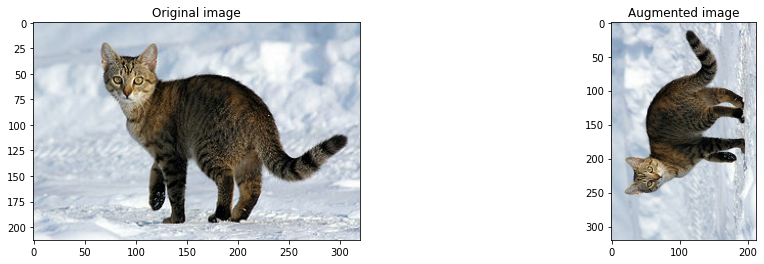

In [9]:
visualize(image, tf.image.rot90(image))

### Recorte

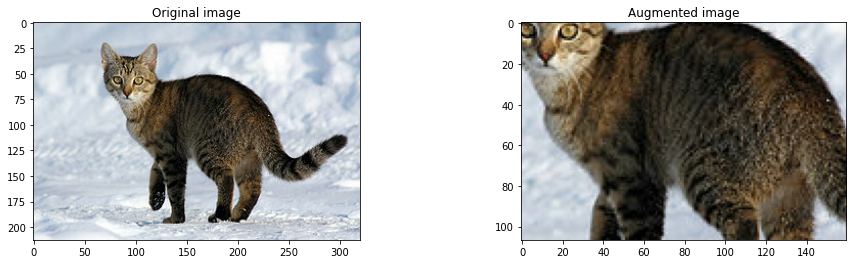

In [10]:
visualize(image, tf.image.central_crop(image, central_fraction=0.5))

## Transformación de un dataset

In [11]:
dataset, info = tfds.load("mnist", as_supervised=True, with_info=True)

train_dataset, test_dataset = dataset["train"], dataset["test"]

num_train_examples = info.splits["train"].num_examples

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [12]:
#
# Funciones para la transformación de las imágenes
#
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label


def augment(image, label):
    image, label = convert(image, label)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_crop_or_pad(image, 34, 34)
    image = tf.image.random_crop(image, size=[28, 28, 1])
    image = tf.image.random_brightness(image, max_delta=0.5)

    return image, label


BATCH_SIZE = 64
NUM_EXAMPLES = 2048

augmented_train_batches = (
    train_dataset.take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples // 4)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

non_augmented_train_batches = (
    train_dataset.take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples // 4)
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_batches = test_dataset.map(convert, num_parallel_calls=AUTOTUNE).batch(
    2 * BATCH_SIZE
)

### Creación y entrenamiento de los modelos

In [13]:
def make_model():

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
            tf.keras.layers.Dense(4096, activation="relu"),
            tf.keras.layers.Dense(4096, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [14]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(
    non_augmented_train_batches, epochs=50, validation_data=validation_batches
)

Epoch 1/50
32/32 [==============================] - 12s 385ms/step - loss: 0.8227 - accuracy: 0.7515 - val_loss: 0.3680 - val_accuracy: 0.8903
Epoch 2/50
32/32 [==============================] - 12s 363ms/step - loss: 0.1862 - accuracy: 0.9419 - val_loss: 0.2899 - val_accuracy: 0.9146
Epoch 3/50
32/32 [==============================] - 13s 394ms/step - loss: 0.0807 - accuracy: 0.9731 - val_loss: 0.2753 - val_accuracy: 0.9225
Epoch 4/50
32/32 [==============================] - 14s 439ms/step - loss: 0.0403 - accuracy: 0.9863 - val_loss: 0.3301 - val_accuracy: 0.9184
Epoch 5/50
32/32 [==============================] - 13s 399ms/step - loss: 0.0626 - accuracy: 0.9814 - val_loss: 0.3565 - val_accuracy: 0.9152
Epoch 6/50
32/32 [==============================] - 13s 393ms/step - loss: 0.0419 - accuracy: 0.9839 - val_loss: 0.3192 - val_accuracy: 0.9312
Epoch 7/50
32/32 [==============================] - 12s 384ms/step - loss: 0.0254 - accuracy: 0.9922 - val_loss: 0.3323 - val_accuracy: 0.9350

In [15]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(
    augmented_train_batches, epochs=50, validation_data=validation_batches
)

Epoch 1/50
32/32 [==============================] - 17s 546ms/step - loss: 2.3056 - accuracy: 0.2954 - val_loss: 1.2132 - val_accuracy: 0.6615
Epoch 2/50
32/32 [==============================] - 17s 531ms/step - loss: 1.3472 - accuracy: 0.5620 - val_loss: 0.7401 - val_accuracy: 0.7667
Epoch 3/50
32/32 [==============================] - 16s 514ms/step - loss: 0.9926 - accuracy: 0.6704 - val_loss: 0.5211 - val_accuracy: 0.8350
Epoch 4/50
32/32 [==============================] - 19s 591ms/step - loss: 0.7875 - accuracy: 0.7358 - val_loss: 0.3650 - val_accuracy: 0.8908
Epoch 5/50
32/32 [==============================] - 18s 573ms/step - loss: 0.7082 - accuracy: 0.7681 - val_loss: 0.3452 - val_accuracy: 0.8968
Epoch 6/50
32/32 [==============================] - 16s 513ms/step - loss: 0.5576 - accuracy: 0.8066 - val_loss: 0.3169 - val_accuracy: 0.8995
Epoch 7/50
32/32 [==============================] - 19s 584ms/step - loss: 0.5626 - accuracy: 0.8169 - val_loss: 0.2866 - val_accuracy: 0.9092

### Resultados

(0.75, 1.0)

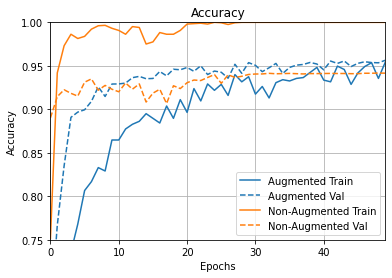

In [16]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot(
    {"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric="accuracy"
)
plt.title("Accuracy")
plt.ylim([0.75, 1])

(0.0, 1.0)

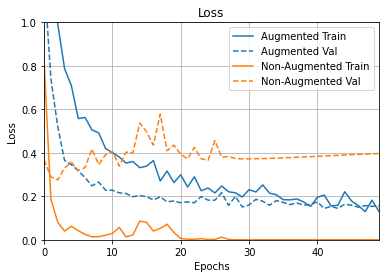

In [17]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric="loss")
plt.title("Loss")
plt.ylim([0, 1])